In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings('ignore', category=UserWarning, message="Line Search failed")

In [101]:
#load data and preprocess
file_path = "/content/drive/MyDrive/ML_HW_4_5/labelled data.csv"
data = pd.read_csv(file_path,index_col=0).fillna(0)
print(data.head())
print(data.isnull().sum())

      Name        FC     logFC    logCPM   P-Value       FDR  SCLC  NSCLC
0  KRT16P5 -1.474275 -0.560006 -2.065784  0.423250  0.645529   0.0    0.0
1  KRT16P3 -1.158475 -0.212227  0.698547  0.598622  0.779482   0.0    0.0
2  KRT16P2  1.785481  0.836313  3.744968  0.060200  0.211667   0.0    0.0
3  KRT16P6 -2.534136 -1.341494  0.404997  0.023716  0.123727   0.0    0.0
4    CRHBP  1.441891  0.527962 -0.015277  0.034942  0.153404   0.0    0.0
Name       0
FC         0
logFC      0
logCPM     0
P-Value    0
FDR        0
SCLC       0
NSCLC      0
dtype: int64


In [102]:
print(data.shape)
print()
print(data.describe)
print()
print(data.info)
print()
print(data.duplicated())
print()
print(data.dtypes)

(19778, 8)

<bound method NDFrame.describe of                Name        FC     logFC    logCPM   P-Value       FDR  SCLC  \
0           KRT16P5 -1.474275 -0.560006 -2.065784  0.423250  0.645529   0.0   
1           KRT16P3 -1.158475 -0.212227  0.698547  0.598622  0.779482   0.0   
2           KRT16P2  1.785481  0.836313  3.744968  0.060200  0.211667   0.0   
3           KRT16P6 -2.534136 -1.341494  0.404997  0.023716  0.123727   0.0   
4             CRHBP  1.441891  0.527962 -0.015277  0.034942  0.153404   0.0   
...             ...       ...       ...       ...       ...       ...   ...   
19773  LOC105369958  2.196994  1.135531  1.382694  0.003199  0.040235   0.0   
19774         ABCC2  3.461301  1.791314  5.336636  0.000671  0.015864   0.0   
19775         TRAV6  3.849574  1.944699 -0.401490  0.000016  0.001372   0.0   
19776  LOC105369904  2.226049  1.154485 -1.006838  0.002616  0.035713   0.0   
19777  LOC101928636  2.279563  1.188757  0.151617  0.000219  0.007721   0.0   

     

In [103]:
print(data.columns[data.isna().any()])
print()

Index([], dtype='object')



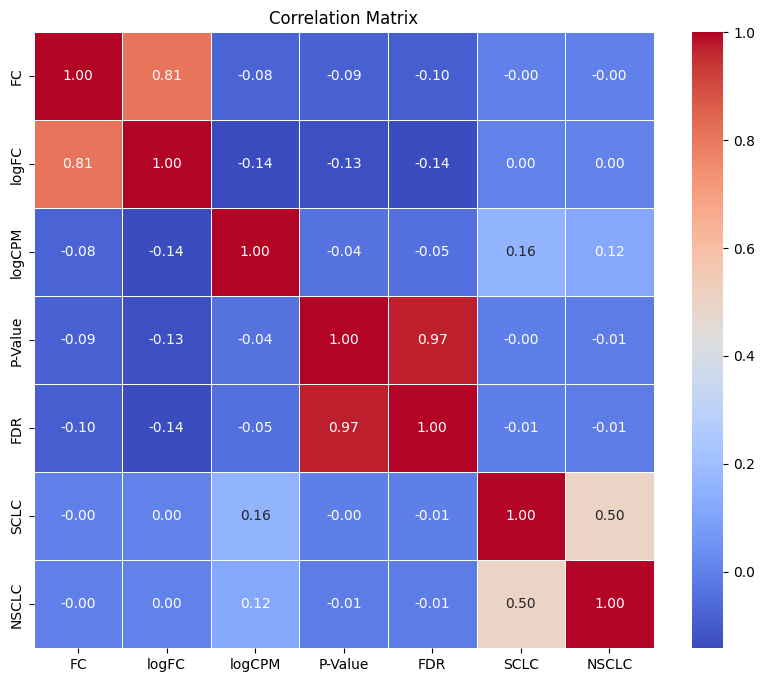

In [89]:
correlation_matrix = data.corr()
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [90]:
#feature selection
features = data[['FC', 'logFC', 'P-Value']]
targets = {'NSCLC': data['NSCLC'], 'SCLC': data['SCLC']}

In [91]:
nsclc = data['NSCLC']
sclc = data['SCLC']

In [92]:
nm = NearMiss()
print('SCLC Original Shape:', Counter(sclc))
features_nm_sclc, nm_sclc = nm.fit_resample(features, sclc)
print('SCLC Resample Shape:', Counter(nm_sclc))
print('NSCLC Original Shape:', Counter(nsclc))
features_nm_nsclc, nm_nsclc = nm.fit_resample(features, nsclc)
print('NSCLC Resample Shape:', Counter(nm_nsclc))

SCLC Original Shape: Counter({0.0: 18857, 1.0: 921})
SCLC Resample Shape: Counter({0.0: 921, 1.0: 921})
NSCLC Original Shape: Counter({0.0: 19087, 1.0: 691})
NSCLC Resample Shape: Counter({0.0: 691, 1.0: 691})


In [93]:
features_sclc = features_nm_sclc
features_nsclc = features_nm_nsclc
sclc = nm_sclc
nsclc = nm_nsclc

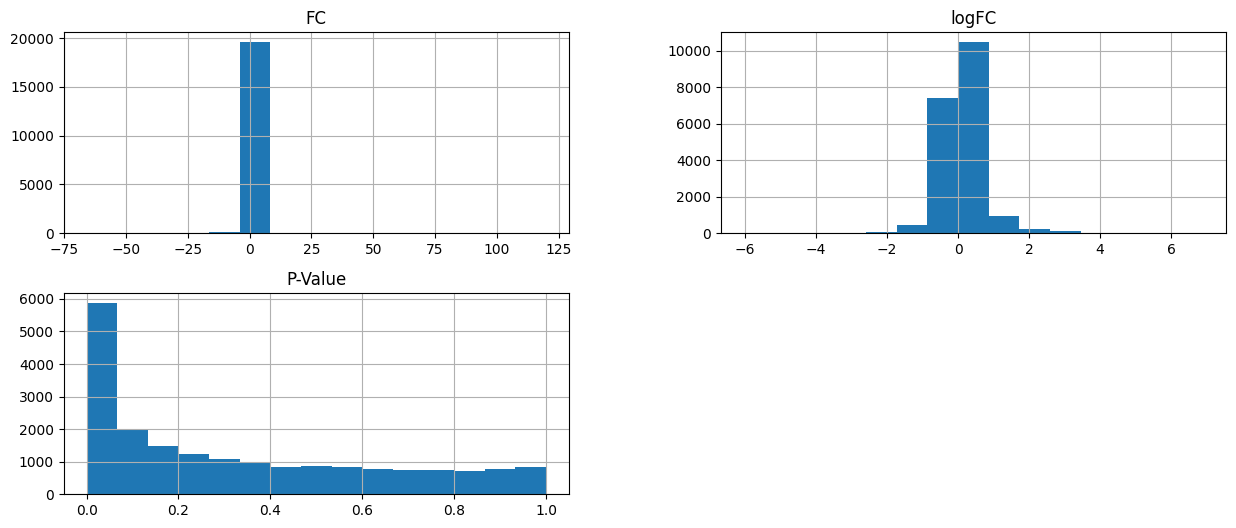

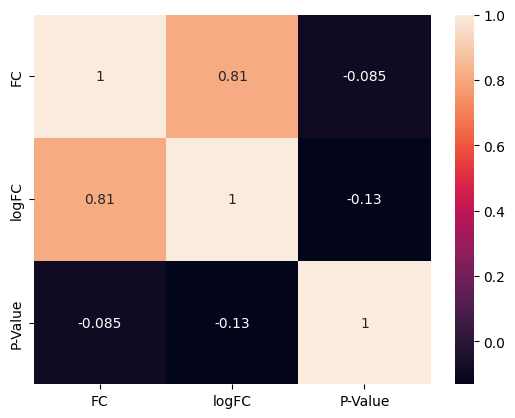

In [94]:
#EDA
#histograms and Correlation Matrix
features.hist(bins=15, figsize=(15, 6), layout=(2, 2))
plt.show()
sns.heatmap(features.corr(), annot=True)
plt.show()

In [95]:
def train_test_and_standardize(features, target, test_size=0.2, random_state=42):
    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test

xtrain_sclc, xtest_sclc, ytrain_sclc, ytest_sclc = train_test_and_standardize(features_sclc, sclc)
xtrain_nsclc, xtest_nsclc, ytrain_nsclc, ytest_nsclc = train_test_and_standardize(features_nsclc, nsclc)

In [96]:
# Update your pipeline with class_weight parameter
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('gradient_boosting', GradientBoostingClassifier())
])

# Function to fit the pipeline with class weights
def fit_pipeline_with_weights(pipeline, x_train, y_train, class_weights):
    pipeline.named_steps['gradient_boosting'].sample_weight = class_weights
    pipeline.fit(x_train, y_train)
    return pipeline

# Update your parameter grid to include more hyperparameters or adjust the ranges
param_grid_gradient_boosting = {
    'gradient_boosting__loss': ['deviance', 'exponential'],
    'gradient_boosting__learning_rate': [0.01, 0.1, 0.2],  # Adjust the learning rate
    'gradient_boosting__n_estimators': [200, 300, 400],  # Increase the number of estimators
    'gradient_boosting__subsample': [1.0, 0.8, 0.6],
    'gradient_boosting__criterion': ['friedman_mse', 'squared_error'],
    'gradient_boosting__min_samples_split': [2, 4, 8],
    'gradient_boosting__min_samples_leaf': [1, 2, 4],
    'gradient_boosting__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'gradient_boosting__max_depth': [3, 5, 7],
    'gradient_boosting__min_impurity_decrease': [0.0, 0.1, 0.2],
    'gradient_boosting__init': [None, 'zero'],
    'gradient_boosting__random_state': [None, 42, 100],
    'gradient_boosting__max_features': [None, 'sqrt', 'log2'],
    'gradient_boosting__verbose': [0, 1, 2],
    'gradient_boosting__max_leaf_nodes': [None, 5, 10],
    'gradient_boosting__warm_start': [False, True],
    'gradient_boosting__validation_fraction': [0.1, 0.2, 0.3],
    'gradient_boosting__n_iter_no_change': [None, 10, 20],
    'gradient_boosting__tol': [1e-4, 1e-3, 1e-2],
    'gradient_boosting__ccp_alpha': [0.0, 0.1, 0.2]
}


#function for GridSearchCV and model evaluation
def evaluate_gradient_boosting(x_train, y_train, x_test, y_test, param_grid):
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, scoring='f1',n_iter = 1000, cv=10, verbose=1, n_jobs=-1)
    random_search.fit(x_train, y_train)  #fit on training data
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    best_gradient_boosting = pipeline.set_params(**best_params)
    best_gradient_boosting.fit(x_train, y_train)  #refit on training data
    y_test_pred = best_gradient_boosting.predict(x_test)  #predict on validation data
    report = classification_report(y_test, y_test_pred)
    return best_params, best_score, report

In [97]:
#evaluate for NSCLC
best_params_nsclc, best_score_nsclc, report_nsclc = evaluate_gradient_boosting(xtrain_nsclc, ytrain_nsclc, xtest_nsclc, ytest_nsclc, param_grid_gradient_boosting)
print("Best Parameters for NSCLC:", best_params_nsclc)
print("Best F1 Score for NSCLC:", best_score_nsclc)
print("Classification Report for NSCLC (Validation Data):\n", report_nsclc)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9954           0.0040            0.32s
         2           0.9911           0.0048            0.40s
         3           0.9871           0.0043            0.41s
         4           0.9820           0.0036            0.42s
         5           0.9785           0.0042            0.41s
         6           0.9741           0.0041            0.41s
         7           0.9698           0.0041            0.41s
         8           0.9658           0.0037            0.41s
         9           0.9614           0.0038            0.41s
        10           0.9581           0.0040            0.41s
        11           0.9525           0.0035            0.46s
        12           0.9493           0.0042            0.46s
        13           0.9445           0.0031            0.46s
        14           0.9398           0.0037            0.45s
  

In [98]:
#evaluate for SCLC
best_params_sclc, best_score_sclc, report_sclc = evaluate_gradient_boosting(xtrain_nsclc, ytrain_nsclc, xtest_nsclc, ytest_nsclc, param_grid_gradient_boosting)
print("Best Parameters for SCLC:", best_params_sclc)
print("Best F1 Score for SCLC:", best_score_sclc)
print("Classification Report for SCLC (Validation Data):\n", report_sclc)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9527           0.0450            0.52s
         2           0.9162           0.0400            0.62s
         3           0.8864           0.0323            0.84s
         4           0.8462           0.0334            0.79s
         5           0.8214           0.0237            0.76s
         6           0.7984           0.0239            0.73s
         7           0.7773           0.0183            0.71s
         8           0.7377           0.0191            0.70s
         9           0.7321           0.0141            0.69s
        10           0.7272           0.0129            0.68s
        20           0.6332           0.0009            0.56s
        30           0.5971           0.0035            0.52s
        40           0.5579          -0.0011            0.52s
      Iter       Train Loss      OOB Improve   Remaining Time 
 